In [2]:
import os

data_dir = '../datasets/jena_climate/'
fname = os.path.join(data_dir, 'jena_climate_2009_2016.csv')

f = open(fname)
data = f.read()
f.close()

In [3]:
lines = data.split('\n')
header = lines[0].split(',')
lines = lines[1:]

print(header)
print(len(lines))

['"Date Time"', '"p (mbar)"', '"T (degC)"', '"Tpot (K)"', '"Tdew (degC)"', '"rh (%)"', '"VPmax (mbar)"', '"VPact (mbar)"', '"VPdef (mbar)"', '"sh (g/kg)"', '"H2OC (mmol/mol)"', '"rho (g/m**3)"', '"wv (m/s)"', '"max. wv (m/s)"', '"wd (deg)"']
420451


### 将数据转换成numpy数组

In [4]:
import numpy as np

float_data = np.zeros((len(lines), len(header) - 1))
for i, line in enumerate(lines):
    values = [float(x) for x in line.split(',')[1:]]
    float_data[i, :] = values

In [5]:
float_data[0]

array([ 9.96520e+02, -8.02000e+00,  2.65400e+02, -8.90000e+00,
        9.33000e+01,  3.33000e+00,  3.11000e+00,  2.20000e-01,
        1.94000e+00,  3.12000e+00,  1.30775e+03,  1.03000e+00,
        1.75000e+00,  1.52300e+02])

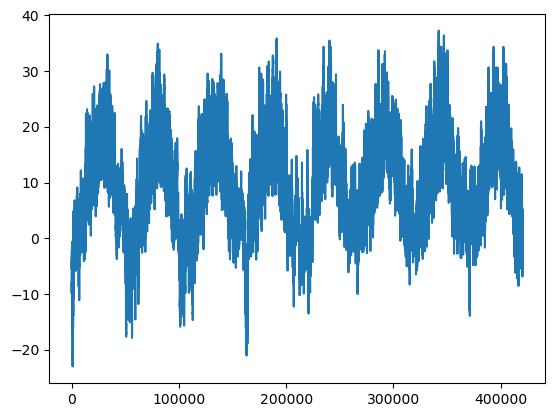

In [6]:
from matplotlib import pyplot as plt

temp = float_data[:, 1]
plt.plot(range(len(temp)), temp)

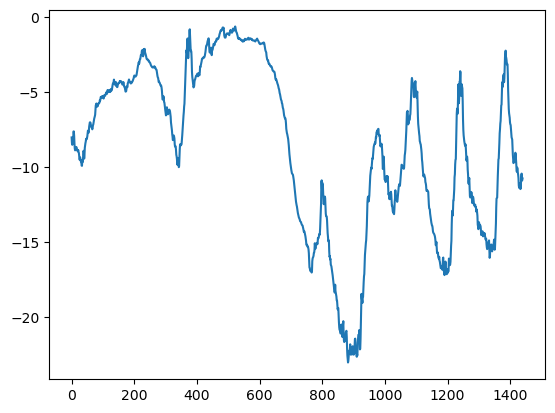

In [7]:
plt.plot(range(1440), temp[:1440])

### 时间序列样本及其目标的生成器

### 数据标准化

In [8]:
mean = float_data[:200000].mean(axis=0)
float_data -= mean
std = float_data[:200000].std(axis=0)
float_data /= std

In [9]:
def generator(data, lookback, delay, min_index, max_index, shuffle=False,
             batch_size=128, step=6):
    if max_index is None:
        max_index = len(data) - delay + 1
    i = min_index + lookback
    
    while 1:
        if shuffle:
            rows = np.random.randint(min_index + lookback, max_index, size=batch_size)
        else:
            if i + batch_size >= max_index:
                i = min_index + lookback
            rows = np.arange(i, min(i + batch_size, max_index))
            i += len(rows)
            
        samples = np.zeros((batch_size, lookback // step, data.shape[-1]))
        targets = np.zeros((len(rows)))
        
        for j, row in enumerate(rows):
            indices = range(row - lookback, row, step)
            samples[j] = data[indices]
            targets[j] = data[row + delay][1]
        
        yield samples, targets

In [10]:
lookback = 1440
step = 6
delay = 144
batch_size = 128

train_gen = generator(float_data, lookback=lookback, delay=delay,
                     min_index=0, max_index=200000,
                     shuffle=True, step=step, batch_size=batch_size)

val_gen = generator(float_data, lookback=lookback, delay=delay,
                    min_index=200001, max_index=300000, step=step,
                    batch_size=batch_size)


test_gen = generator(float_data,lookback=lookback,delay=delay,
                 min_index=300001,max_index=None,step=step,
                 batch_size=batch_size)


val_steps = (300000 - 200001 - lookback) //batch_size


test_steps = (len(float_data) - 300001 - lookback) //batch_size

### 技术符合常识的基准方法MAE

In [11]:
def evaluate_native_method():
    batch_maes = []
    for step in range(val_steps):
        samples, targets = next(val_gen)
        preds = samples[:, -1, 1]
        mae = np.mean(np.abs(preds - targets))
        batch_maes.append(mae)
    print(np.mean(batch_maes))
    
evaluate_native_method()

0.2897359729905486


### 使用密集连接神经网络训练

In [12]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

model = Sequential()
model.add(layers.Flatten(input_shape=(lookback//step, float_data.shape[-1])))
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dense(1))

Metal device set to: Apple M1


In [13]:
model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit(train_gen, steps_per_epoch=500,
                             epochs=20,
                             validation_data=val_gen,
                             validation_steps=val_steps)


Epoch 1/20


2023-05-21 19:46:11.827373: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


500/500 [==============================] - 5s 9ms/step - loss: 1.0395 - val_loss: 0.4351
Epoch 2/20
500/500 [==============================] - 5s 9ms/step - loss: 0.3466 - val_loss: 0.3147
Epoch 3/20
500/500 [==============================] - 5s 9ms/step - loss: 0.2804 - val_loss: 0.2999
Epoch 4/20
500/500 [==============================] - 5s 9ms/step - loss: 0.2610 - val_loss: 0.2995
Epoch 5/20
500/500 [==============================] - 5s 9ms/step - loss: 0.2503 - val_loss: 0.3256
Epoch 6/20
500/500 [==============================] - 5s 9ms/step - loss: 0.2454 - val_loss: 0.3548
Epoch 7/20
500/500 [==============================] - 5s 9ms/step - loss: 0.2355 - val_loss: 0.3383
Epoch 8/20
500/500 [==============================] - 5s 9ms/step - loss: 0.2292 - val_loss: 0.3126
Epoch 9/20
500/500 [==============================] - 5s 9ms/step - loss: 0.2264 - val_loss: 0.3244
Epoch 10/20
500/500 [==============================] - 5s 9ms/step - loss: 0.2239 - val_loss: 0.3170
Epoch 11/2

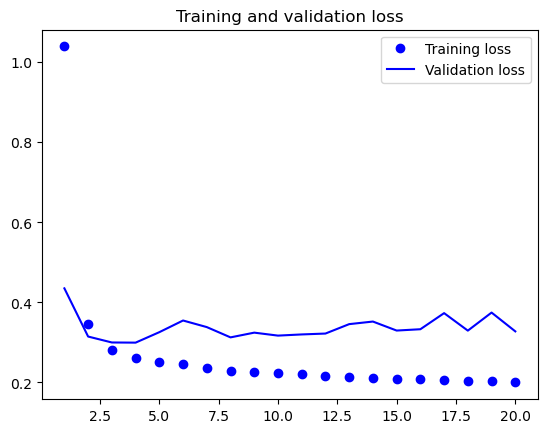

In [14]:
import matplotlib.pyplot as plt

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure()

epochs = range(1, len(loss)+1)
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')

plt.legend()

plt.show()

### 使用GRU模型训练

In [15]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

model = Sequential()
model.add(layers.GRU(32, input_shape=(None, float_data.shape[-1])))
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')

history = model.fit(train_gen, steps_per_epoch=500, epochs=20,
                   validation_data=val_gen,
                   validation_steps=val_steps)

Epoch 1/20
500/500 [==============================] - 18s 36ms/step - loss: 0.3062 - val_loss: 0.2759
Epoch 2/20
500/500 [==============================] - 18s 35ms/step - loss: 0.2897 - val_loss: 0.2717
Epoch 3/20
500/500 [==============================] - 18s 36ms/step - loss: 0.2855 - val_loss: 0.2674
Epoch 4/20
500/500 [==============================] - 18s 36ms/step - loss: 0.2825 - val_loss: 0.2678
Epoch 5/20
500/500 [==============================] - 18s 36ms/step - loss: 0.2786 - val_loss: 0.2698
Epoch 6/20
500/500 [==============================] - 18s 35ms/step - loss: 0.2801 - val_loss: 0.2736
Epoch 7/20
500/500 [==============================] - 18s 35ms/step - loss: 0.2769 - val_loss: 0.2697
Epoch 8/20
500/500 [==============================] - 18s 36ms/step - loss: 0.2731 - val_loss: 0.2625
Epoch 9/20
500/500 [==============================] - 18s 35ms/step - loss: 0.2705 - val_loss: 0.2671
Epoch 10/20
500/500 [==============================] - 18s 36ms/step - loss: 0.269

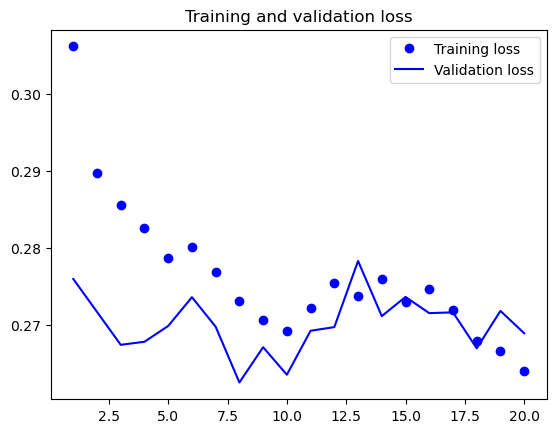

In [16]:
import matplotlib.pyplot as plt

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure()

epochs = range(1, len(loss)+1)
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')

plt.legend()

plt.show()

### 使用dropout正则化训练GRU模型

In [17]:
# from keras.models import Sequential
# from keras import layers
# from keras.optimizers import RMSprop

# model = Sequential()
# model.add(layers.GRU(32, dropout=0.2, recurrent_dropout=0.2,
#                     input_shape=(None, float_data.shape[-1])))
# model.add(layers.Dense(1))

# model.compile(optimizer=RMSprop(), loss='mae')

# history = model.fit(train_gen, steps_per_epoch=500, epochs=40, 
#                    validation_data= val_gen,
#                    validation_steps=val_steps)

### 使用LSTM

In [18]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

model = Sequential()
model.add(layers.LSTM(32,
                      input_shape=(None, float_data.shape[-1])))
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss=['mae'])

history = model.fit(train_gen, steps_per_epoch=100, epochs=30,
                   validation_data=val_gen,
                   validation_steps=val_steps)

Epoch 1/30
100/100 [==============================] - 9s 88ms/step - loss: 0.3471 - val_loss: 0.2868
Epoch 2/30
100/100 [==============================] - 9s 87ms/step - loss: 0.3003 - val_loss: 0.2795
Epoch 3/30
100/100 [==============================] - 9s 87ms/step - loss: 0.2892 - val_loss: 0.2760
Epoch 4/30
100/100 [==============================] - 9s 87ms/step - loss: 0.2842 - val_loss: 0.2745
Epoch 5/30
100/100 [==============================] - 9s 87ms/step - loss: 0.2807 - val_loss: 0.2710
Epoch 6/30
100/100 [==============================] - 9s 87ms/step - loss: 0.2770 - val_loss: 0.2683
Epoch 7/30
100/100 [==============================] - 9s 87ms/step - loss: 0.2788 - val_loss: 0.2759
Epoch 8/30
100/100 [==============================] - 9s 87ms/step - loss: 0.2720 - val_loss: 0.2674
Epoch 9/30
100/100 [==============================] - 9s 87ms/step - loss: 0.2667 - val_loss: 0.2678
Epoch 10/30
100/100 [==============================] - 9s 87ms/step - loss: 0.2673 - val_lo

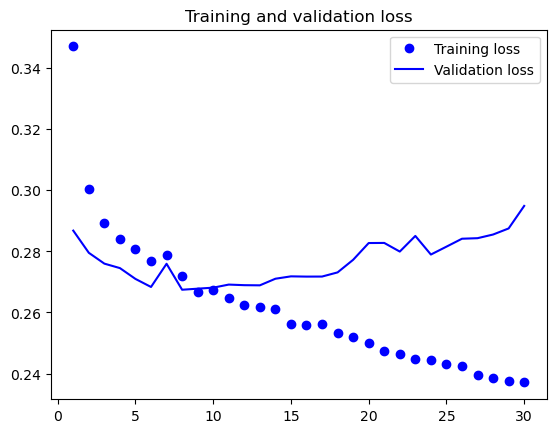

In [19]:
import matplotlib.pyplot as plt

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure()

epochs = range(1, len(loss)+1)
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')

plt.legend()

plt.show()